<a href="https://colab.research.google.com/github/yassarmohammed87/SpaceShipTitanic-Kaggle/blob/main/Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c spaceship-titanic


  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 74.5MB/s]


In [ ]:
!unzip spaceship-titanic.zip

Archive:  spaceship-titanic.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!mkdir spaceTitanic 
!cp train.csv ./spaceTitanic/
!cp test.csv ./spaceTitanic/
!rm -rf test.csv
!rm -rf train.csv

In [ ]:
!cp -r ./spaceTitanic ./drive/MyDrive/  

In [ ]:
!mkdir ./drive/MyDrive/spaceTitanic/models

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn_pandas import CategoricalImputer
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from feature_engine 



In [ ]:
df=pd.read_csv('./drive/MyDrive/spaceTitanic/train.csv')
# df['Transported']=df['Transported'].astype(np.int64)

In [ ]:
df.head(100)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0103_01,Earth,False,F/24/S,TRAPPIST-1e,24.0,False,0.0,NaN,0.0,0.0,17.0,Arlen Mclainez,True
96,0103_02,Earth,True,G/18/S,55 Cancri e,9.0,False,0.0,0.0,0.0,0.0,0.0,Shaele Mclainez,True
97,0103_03,Earth,True,G/18/S,TRAPPIST-1e,6.0,False,0.0,0.0,0.0,0.0,0.0,Fanne Mclainez,False
98,0105_01,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.0,Carry Cleachrand,False


In [ ]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [ ]:
def category_comp_plot(field):
  col_series=df[field].value_counts().index
  
  fig, axs = plt.subplots(1, len(col_series), figsize=(12, 5))
  for i,category in enumerate(col_series):
    plt.subplot(1,len(col_series),i+1)
    sns.countplot(data=df.loc[df[field]==category],x='Transported')
    plt.title(category)

plt.subplots_adjust(left=2,right=3)
    


<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


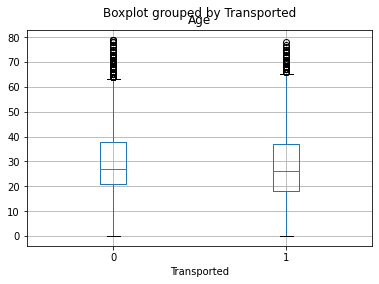

In [ ]:
df.boxplot(column='Age',by='Transported')

###**Checking significance of VIP column**

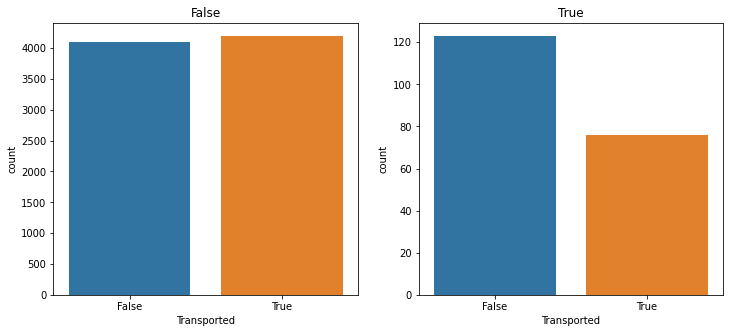

In [ ]:
category_comp_plot('VIP')


In [ ]:
df.groupby('VIP')['Transported'].agg(['count','sum',lambda x:x.sum()/pd.Series(x).count()])

,count,sum,<lambda_0>
VIP,,,
False,8291,4198,0.506332
True,199,76,0.381910


Can conclude that being a vip isnt contributing heavily to the target variable

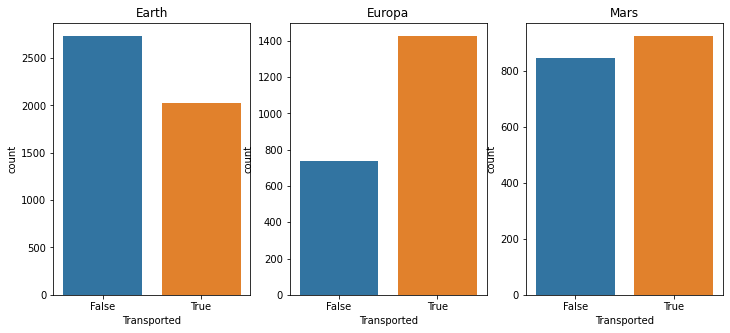

In [ ]:
category_comp_plot('HomePlanet')

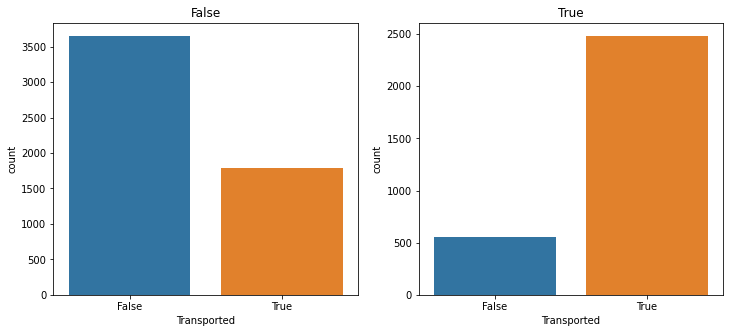

In [ ]:
catergory_comp_plot('CryoSleep')

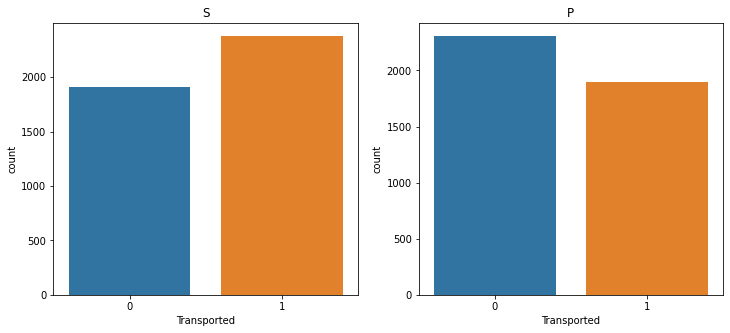

In [ ]:
df['Port']=df['Cabin'].str[-1]
category_comp_plot('Port')

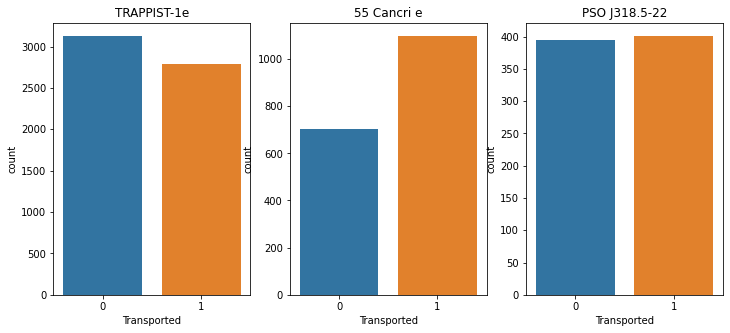

In [ ]:
category_comp_plot('Destination')

In [ ]:
empRowCount={}
for i in df.columns:
  empRowCount[i]=df[i].isna().sum()
  # print(df[i].isna().sum())
pd.concat([pd.DataFrame(empRowCount,index=['Null Count']).T,df.dtypes],axis=1)

,Null Count,0
PassengerId,0,object
HomePlanet,201,object
CryoSleep,217,object
Cabin,199,object
Destination,182,object
Age,179,float64
VIP,203,object
RoomService,181,float64
FoodCourt,183,float64
ShoppingMall,208,float64


In [ ]:
class cat_Imputer(BaseEstimator,TransformerMixin):
  def __init__(self,categ_cols):
    self.categ_cols=categ_cols
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    
    
    true_transported=X['Transported'].value_counts().loc[True]
    false_transported=X['Transported'].value_counts().loc[False]
    for i in self.categ_cols:
      true_prob=[]
      false_prob=[]
      tp=X.loc[~X[i].isna()].copy(deep=True)
      
      for j in tp[i].value_counts().index:
        true_prob.append(tp.loc[(X[i]==j) & (tp['Transported']==True)].shape[0]/true_transported)
        false_prob.append(tp.loc[(X[i]==j) & (tp['Transported']==False)].shape[0]/false_transported)

        # try:
        #   true_prob.append(X[~df[i].isna()].groupby('Transported').agg({i:[(j,lambda x:x.str.count().sum()/true_transported)]}).loc[True][(i,j)])
        #   false_prob.append(X[~df[i].isna()].groupby('Transported').agg({i:[(j,lambda x:x.str.count().sum()/false_transported)]}).loc[False][(i,j)])
        # except:
        #   true_prob.append(X[~df[i].isna()].groupby('Transported').agg({i:[(j,lambda x:x.count().sum()/true_transported)]}).loc[True][(i,j)])
        #   false_prob.append(X[~df[i].isna()].groupby('Transported').agg({i:[(j,lambda x:x.count().sum()/false_transported)]}).loc[False][(i,j)])
      X.loc[(X[i].isna()) & (X['Transported']==True),i]=np.random.choice(X[i].value_counts().index,
                                                                                X.loc[(X[i].isna()) & (X['Transported']==True),i].shape,
                                                                                p=true_prob/sum(true_prob))
      X.loc[(X[i].isna()) & (X['Transported']==False),i]=np.random.choice(X[i].value_counts().index,
                                                                                X.loc[(X[i].isna()) & (X['Transported']==False),i].shape,
                                                                                p=true_prob/sum(true_prob))
    
    return X

class Int_Imputer(BaseEstimator,TransformerMixin):
  def __init__(self,cols):
    self.cols=cols
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    imputer=SimpleImputer(strategy="median")
    imputer.fit(X[self.cols])
    X[self.cols]=imputer.transform(X[self.cols])
  
    return X
  


class AttriAdder(BaseEstimator,TransformerMixin):

  def __init__(self):
    pass
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    X['TotalSpent']=X['RoomService']+X['Spa']+X['VRDeck']
    
    X['side']=X['Cabin'].str[-1]

    return X


class OrdEncoding(BaseEstimator,TransformerMixin):

  def __init__(self,cols):
    self.cols=cols
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    ord=OrdinalEncoder()
    for col in self.cols:
      X[col]=ord.fit_transform(X[[col]])

    return X

class OneHot(BaseEstimator,TransformerMixin):

  def __init__(self,cols):
    self.cols=cols
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    one=OneHotEncoder(sparse=False)
    for col in self.cols:

      X[list(one.categories_[0])]=pd.DataFrame(one.fit_transform(X[[col]]))

    return X

class TypeChange(BaseEstimator,TransformerMixin):

  def __init__(self,cols_dict):
    self.cols_dict=cols_dict
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    for col in self.cols_dict:
      X[col]=X[col].astype(self.cols_dict[col])
    return X

class Dropcols(BaseEstimator,TransformerMixin):

  def __init__(self,to_drop):
    self.to_drop=to_drop
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    X=X.drop(columns=self.to_drop,axis=1)
    return X

class Keepcols(BaseEstimator,TransformerMixin):

  def __init__(self,to_keep):
    self.to_keep=to_keep
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    X=X[self.to_keep]
    return X

class Scaler(BaseEstimator,TransformerMixin):
  def __init__(self,cols=None):
    self.cols=cols
    pass
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    if self.cols==None:
      self.cols=X.columns
    scaler=StandardScaler()
    X[self.cols]=scaler.fit_transform(X[self.cols])
    return X

class ModeImputer(BaseEstimator,TransformerMixin):
  def __init__(self,cols):
    self.cols=cols
    
  def fit(self,X,y=None):
    return None
  def fit_transform(self,X,y=None):
    for i in self.cols:
      cat_imputer=CategoricalImputer()
      X[i]=cat_imputer.fit_transform(X[i])
    return X

class Binner(BaseEstimator,TransformerMixin):
  def __init__(self,cols,cats=4):
    self.cols=cols
    self.cats=cats
  def fit(self,X,y=None):
    return None
  def fit_transform(self,X,y=None):
    for i in self.cols:
      X[i]=pd.qcut(X[i],self.cats,labels=False)
    return X







In [ ]:
df=pd.read_csv('./drive/MyDrive/spaceTitanic/train.csv')

In [ ]:
df['deck']=df['Cabin'].str[0]
deck_to_cab={'A':'Europa','C':'Europa','B':'Europa','T':'Europa','D':'Mars','E':'Earth','G':'Earth','F':'Earth'}
for i in deck_to_cab:
  df.loc[(df['deck']==i) & df['HomePlanet'].isna(),'HomePlanet']=df.loc[(df['deck']==i) & df['HomePlanet'].isna(),'HomePlanet'].fillna(
      value=deck_to_cab.get(i,'F'))

In [ ]:
int_imp=Int_Imputer(['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'])
df=int_imp.fit_transform(df)
attri_adder=AttriAdder()
df=attri_adder.fit_transform(df)
modeImp=ModeImputer(['HomePlanet','CryoSleep','side','Destination','VIP'])
df=modeImp.fit_transform(df)
type_change=TypeChange({'Transported':np.int64,'CryoSleep':np.int64,'VIP':np.int64})
df=type_change.fit_transform(df)
# one_hot=OneHot(['HomePlanet','side','Destination'])
# df=one_hot.fit_transform(df)
# drp_cls=Dropcols(['Name','Cabin','Destination','HomePlanet','side','PassengerId','RoomService','VRDeck','Spa'])
# df=drp_cls.fit_transform(df)
# bin=Binner(['Age'],4)
# df=bin.fit_transform(df)
keep_cls=Keepcols(['TotalSpent','CryoSleep','HomePlanet','side','Destination','Transported'])
df=keep_cls.fit_transform(df)
scaler=Scaler(['TotalSpent','CryoSleep'])
df=scaler.fit_transform(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
df

,TotalSpent,CryoSleep,HomePlanet,side,Destination,Transported
0,-0.449452,-0.732770,Europa,P,TRAPPIST-1e,0
1,-0.066015,-0.732770,Earth,S,TRAPPIST-1e,1
2,3.268580,-0.732770,Europa,S,TRAPPIST-1e,0
3,1.474290,-0.732770,Europa,S,TRAPPIST-1e,0
4,0.025748,-0.732770,Earth,S,TRAPPIST-1e,1
...,...,...,...,...,...,...
8688,0.488386,-0.732770,Europa,P,55 Cancri e,0
8689,-0.449452,1.364685,Earth,S,PSO J318.5-22,0
8690,-0.448906,-0.732770,Earth,S,TRAPPIST-1e,1
8691,1.510339,-0.732770,Europa,S,55 Cancri e,0


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import joblib
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

In [ ]:
labels=df['Transported']
df=df.drop(columns=['Transported'])
train,test,train_labels,test_labels=train_test_split(df,labels,test_size=0.1,random_state=42,shuffle=True)

## Function For HyperParamter Tuning

In [ ]:
def randomSearcher(model,params,name):
  rs=RandomizedSearchCV(model,param_distributions=params,scoring='accuracy',n_iter=20)
  rs.fit(train,train_labels)
  joblib.dump(rs.best_estimator_,'./drive/MyDrive/spaceTitanic/models/'+name)


# Ada Boost HyperParameter Tuning

In [ ]:
max_depth=[int(x) for x in np.linspace(10,110,num=11)]
ada_params = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "base_estimator__max_depth":max_depth
             }
dtree=DecisionTreeClassifier(random_state=42)
abc=AdaBoostClassifier(dtree)
randomSearcher(abc,ada_params,'abc_h_noTotalSpent')
abc=joblib.load('./drive/MyDrive/spaceTitanic/models/abc_h_noTotalSpent')



In [ ]:
abc=joblib.load('./drive/MyDrive/spaceTitanic/models/abcBestMode')

# SVC HyperParameter Tuning

In [ ]:
svc_params = {'C': [0.1, 1, 10],'kernel':['linear','poly','rbf']}
svc=SVC()
randomSearcher(svc,svc_params,'svc_h_classic')
svc=joblib.load('./drive/MyDrive/spaceTitanic/models/svc_h_classic')


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


# Random Forest HyperParameter Tuning

In [ ]:
n_estimators=[int(x) for x in np.linspace(start=10,stop=100,num=10)]
max_features=['auto','sqrt']
max_depth=[int(x) for x in np.linspace(10,110,num=11)]
max_depth.append(None)
min_samples_split=[2,5,10]
min_samples_leaf=[1,2,4]
bootstrap=[True,False]
rdm_params={'n_estimators':n_estimators,'max_features':max_features,'max_depth':max_depth,'min_samples_split':min_samples_split
                           ,'min_samples_leaf':min_samples_leaf,'bootstrap':bootstrap}
rf=RandomForestClassifier()
randomSearcher(rf,rdm_params,'rf_h_noTotalSpent')
rf=joblib.load('./drive/MyDrive/spaceTitanic/models/rf_h_noTotalSpent')


# Support Vector Machine

In [ ]:
svc=SVC()
joblib.dump(svc,'./drive/MyDrive/spaceTitanic/svc_noh_0')

# Voting Classifier

In [ ]:
rf=joblib.dump(svc,'./drive/MyDrive/spaceTitanic/svc_noh_0')
Ada=rf=joblib.load('./drive/MyDrive/spaceTitanic/models/abcBest')
svc=rf=joblib.load('./drive/MyDrive/spaceTitanic/models/randomForestBest')

vC=VotingClassifier(estimators=[('rf',rf),('Ada',Ada),('svc',svc)],voting='soft')


## XG BOOST

In [ ]:
xg=xgb.XGBClassifier()


In [ ]:
model_CBC2 = CatBoostClassifier(cat_features=['HomePlanet','side','Destination'],eval_metric='Accuracy',depth=10, l2_leaf_reg=1, learning_rate=0.1)
model_CBC2.fit(train,train_labels,eval_set=(test, test_labels),verbose=False)


## CatBoost Classifier

In [ ]:
model_CBC = CatBoostClassifier(cat_features=['HomePlanet','side','Destination'],eval_metric='Accuracy')
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
grid_search_result = model_CBC.grid_search(grid, 
                                       X=train, 
                                       y=train_labels, 
                                       plot=True)
# model_CBC.fit(train,train_labels,eval_set=(test, test_labels),verbose=False)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
26:	learn: 0.7924257	test: 0.7795527	best: 0.7827476 (1)	total: 328ms	remaining: 11.8s
27:	learn: 0.7922659	test: 0.7789137	best: 0.7827476 (1)	total: 339ms	remaining: 11.8s
28:	learn: 0.7924257	test: 0.7757188	best: 0.7827476 (1)	total: 349ms	remaining: 11.7s
29:	learn: 0.7924257	test: 0.7789137	best: 0.7827476 (1)	total: 356ms	remaining: 11.5s
30:	learn: 0.7913071	test: 0.7769968	best: 0.7827476 (1)	total: 362ms	remaining: 11.3s
31:	learn: 0.7919463	test: 0.7789137	best: 0.7827476 (1)	total: 379ms	remaining: 11.5s
32:	learn: 0.7925855	test: 0.7757188	best: 0.7827476 (1)	total: 384ms	remaining: 11.2s
33:	learn: 0.7925855	test: 0.7776358	best: 0.7827476 (1)	total: 400ms	remaining: 11.4s
34:	learn: 0.7929051	test: 0.7757188	best: 0.7827476 (1)	total: 404ms	remaining: 11.1s
35:	learn: 0.7917865	test: 0.7757188	best: 0.7827476 (1)	total: 411ms	remaining: 11s
36:	learn: 0.7929051	test: 0.7757188	best: 0.7827476 (1)	total: 420ms	remaining: 

In [ ]:
grid_search_result['params']

{'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

In [ ]:
model_CBC2.best_score_

{'learn': {'Accuracy': 0.8872555285696024, 'Logloss': 0.26200482011874565},
 'validation': {'Accuracy': 0.7735632183908046, 'Logloss': 0.4803675657371142}}

## Logging Scores

In [ ]:
def score_logger(train,test,train_labels,test_labels,model):
  model.fit(train,train_labels)
  training_acc=accuracy_score(train_labels,model.predict(train))
  test_acc=accuracy_score(test_labels,model.predict(test))
  score_log=pd.read_csv('./drive/MyDrive/spaceTitanic/score_log.csv')
  emp=','.join(train.columns)
  score_log=score_log.append(pd.DataFrame({'Columns':emp,'Training Accuracy':training_acc,'Test Accuracy':test_acc,'Model':model.__class__.__name__},index=range(0,1)),ignore_index=True)
  score_log.to_csv('./drive/MyDrive/spaceTitanic/score_log.csv',index=False)
  # files.download('./drive/MyDrive/spaceTitanic/score_log.csv')
  print(score_log)

  
  


In [ ]:
score_logger(train,test,train_labels,test_labels,model_CBC)

Learning rate set to 0.024797
0:	learn: 0.6798442	total: 49ms	remaining: 49s
1:	learn: 0.6673623	total: 52.2ms	remaining: 26s
2:	learn: 0.6552613	total: 55.1ms	remaining: 18.3s
3:	learn: 0.6435136	total: 58ms	remaining: 14.4s
4:	learn: 0.6316873	total: 61.7ms	remaining: 12.3s
5:	learn: 0.6215428	total: 66ms	remaining: 10.9s
6:	learn: 0.6123944	total: 69.2ms	remaining: 9.81s
7:	learn: 0.6039813	total: 72ms	remaining: 8.93s
8:	learn: 0.5945856	total: 75.2ms	remaining: 8.28s
9:	learn: 0.5864751	total: 77.9ms	remaining: 7.71s
10:	learn: 0.5783843	total: 81ms	remaining: 7.28s
11:	learn: 0.5713451	total: 84ms	remaining: 6.92s
12:	learn: 0.5643878	total: 87.2ms	remaining: 6.62s
13:	learn: 0.5579461	total: 91.4ms	remaining: 6.43s
14:	learn: 0.5522368	total: 94.2ms	remaining: 6.19s
15:	learn: 0.5459228	total: 97ms	remaining: 5.96s
16:	learn: 0.5401979	total: 99.7ms	remaining: 5.76s
17:	learn: 0.5358189	total: 102ms	remaining: 5.58s
18:	learn: 0.5319261	total: 105ms	remaining: 5.42s
19:	learn: 0

In [ ]:
  score_log=pd.read_csv('./drive/MyDrive/spaceTitanic/score_log.csv')


In [ ]:
score_log

,Columns,Training Accuracy,Test Accuracy,Model
0,"TotalSpent,CryoSleep,Earth",0.800205,0.751724,RandomForestClassifier
1,"TotalSpent,CryoSleep,Earth,Europa",0.809408,0.756322,RandomForestClassifier
2,"TotalSpent,CryoSleep,Earth,Europa",0.809792,0.760920,RandomForestClassifier
3,"TotalSpent,CryoSleep,Earth,Europa,P,S,55 Cancri e",0.814266,0.748276,RandomForestClassifier
4,"TotalSpent,CryoSleep,Earth,Europa",0.807619,0.756322,RandomForestClassifier
5,"TotalSpent,CryoSleep,Earth,Europa",0.785504,0.772414,SVC
6,"TotalSpent,CryoSleep,Earth,Europa",0.785249,0.763218,SVC
7,"TotalSpent,CryoSleep,Earth,Europa",0.789978,0.770115,AdaBoostClassifier
8,"TotalSpent,CryoSleep,Earth,Europa",0.851719,0.740230,AdaBoostClassifier
9,"TotalSpent,CryoSleep,Earth,Europa",0.808386,0.759770,RandomForestClassifier


## NEURAL NETWORKS

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
 

In [ ]:
df

,CryoSleep,VIP,Transported,TotalSpent,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,P,S
0,0,0,0,-0.449452,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0,0,1,-0.066015,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0,1,0,3.268580,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,0,0,1.474290,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0,0,1,0.025748,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,1,0,0.488386,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
8689,1,0,0,-0.449452,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8690,0,0,1,-0.448906,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8691,0,0,0,1.510339,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
model=keras.models.Sequential()
model.add(keras.layers.Input(shape=(df.columns.shape[0],)))
model.add(keras.layers.Dense(100,kernel_initializer='he_normal'))
model.add(keras.layers.LeakyReLU(alpha=0.05))
model.add(keras.layers.Dense(100,activation='relu'))
model.add(keras.layers.Dense(2,activation='sigmoid',kernel_initializer='he_normal'))
model.compile(loss=keras.losses.CategoricalCrossentropy(),optimizer="Nadam",metrics=['accuracy'])


In [ ]:
labels=df['Transported']
df=df.drop(columns=['Transported'])

In [ ]:
label_tensor=tf.one_hot(np.array(labels),2)

In [ ]:
history=model.fit(df,label_tensor,epochs=50,callbacks=[
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-3 * 10 ** (epoch / 30)
        )
    ])

Epoch 1/50
272/272 [==============================] - 1s 3ms/step - loss: 0.4447 - accuracy: 0.7888 - lr: 0.0010
Epoch 2/50
272/272 [==============================] - 1s 4ms/step - loss: 0.4442 - accuracy: 0.7865 - lr: 0.0011
Epoch 3/50
272/272 [==============================] - 1s 4ms/step - loss: 0.4444 - accuracy: 0.7861 - lr: 0.0012
Epoch 4/50
272/272 [==============================] - 1s 2ms/step - loss: 0.4454 - accuracy: 0.7860 - lr: 0.0013
Epoch 5/50
272/272 [==============================] - 0s 2ms/step - loss: 0.4446 - accuracy: 0.7852 - lr: 0.0014
Epoch 6/50
272/272 [==============================] - 0s 2ms/step - loss: 0.4449 - accuracy: 0.7866 - lr: 0.0015
Epoch 7/50
272/272 [==============================] - 0s 2ms/step - loss: 0.4456 - accuracy: 0.7876 - lr: 0.0016
Epoch 8/50
272/272 [==============================] - 0s 2ms/step - loss: 0.4457 - accuracy: 0.7874 - lr: 0.0017
Epoch 9/50
272/272 [==============================] - 0s 2ms/step - loss: 0.4448 - accuracy: 0.7

In [ ]:
df

,CryoSleep,VIP,TotalSpent,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,P,S
0,0,0,-0.449452,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0,0,-0.066015,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0,1,3.268580,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,0,1.474290,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0,0,0.025748,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
8688,0,1,0.488386,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
8689,1,0,-0.449452,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8690,0,0,-0.448906,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8691,0,0,1.510339,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 100)               1200      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 100)               0         
                                                                 
 dense_31 (Dense)            (None, 100)               10100     
                                                                 
 dense_32 (Dense)            (None, 1)                 101       
                                                                 
Total params: 11,401
Trainable params: 11,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
df

,CryoSleep,VIP,TotalSpent,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,P,S
0,0,0,-0.449452,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0,0,-0.066015,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0,1,3.268580,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,0,0,1.474290,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0,0,0.025748,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
8688,0,1,0.488386,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
8689,1,0,-0.449452,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8690,0,0,-0.448906,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8691,0,0,1.510339,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
model.predict(df)

array([[0.7281143 ],
       [0.17564508],
       [0.00140086],
       ...,
       [0.61539495],
       [0.12611422],
       [0.8608341 ]], dtype=float32)

In [ ]:
pd.DataFrame({'Cols':','.join(['TotalSpent','CryoSleep','Earth','Europa'])},index=range(0,1)).to_csv('./drive/MyDrive/spaceTitanic/column_list.csv')